## Preparacion de los datos 

### 2.1 Carga de datos (Parquet → CSV)
Cargamos el dataset procesado `TelecomX_model_ready.parquet`, inspeccionamos su estructura y persistimos una versión CSV (`telecomX_model_ready.csv`). También intentamos detectar automáticamente la variable objetivo (churn/cancelación).

Pasos:
1. Cargar parquet con `pandas`.
2. Explorar forma, esquema, valores nulos y distribuciones básicas.
3. Detección heurística de la columna objetivo.
4. Exportar a CSV para referencias externas.

> Ajusta manualmente la variable objetivo si la detección automática no es correcta.

In [21]:
# 2.1 Carga e inspección de datos
import pandas as pd
from pathlib import Path

parquet_path = Path('data') / 'TelecomX_model_ready.parquet'
csv_path = Path('data') / 'telecomX_model_ready.csv'

# Carga parquet
df = pd.read_parquet(parquet_path)
print(f"Filas: {df.shape[0]}  Columnas: {df.shape[1]}")
print('\nTipos de datos:')
print(df.dtypes.head(20))

print('\nValores nulos por columna (top 20):')
print(df.isna().sum().sort_values(ascending=False).head(20))

# Heurística de detección de target
candidate_names = [c for c in df.columns if c.lower() in ['churn','cancel','canceled','cancelled','churn_flag','is_churn','cancelacion','cancelación'] or 'churn' in c.lower()]
print('\nCandidatos a variable objetivo:', candidate_names)

# Selección automática simple
if candidate_names:
    target_col = candidate_names[0]
else:
    # Ajustar manualmente si no detecta
    target_col = 'churn'  # Cambia si es diferente

print('Variable objetivo asumida:', target_col)

# Exportar a CSV
if not csv_path.exists():
    df.to_csv(csv_path, index=False)
    print(f'CSV guardado en {csv_path}')
else:
    print('CSV ya existía, no se sobreescribe.')

df.head()

Filas: 7267  Columnas: 32

Tipos de datos:
customer_SeniorCitizen                           float64
customer_Partner                                 float64
customer_Dependents                              float64
customer_tenure                                  float64
phone_PhoneService                               float64
account_PaperlessBilling                         float64
account_Charges.Monthly                          float64
account_Charges.Total                            float64
cuentas_diarias                                  float64
customer_gender_male                                bool
phone_MultipleLines_no phone service                bool
phone_MultipleLines_yes                             bool
internet_InternetService_fiber optic                bool
internet_InternetService_no                         bool
internet_OnlineSecurity_no internet service         bool
internet_OnlineSecurity_yes                         bool
internet_OnlineBackup_no internet service    

,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,account_PaperlessBilling,account_Charges.Monthly,account_Charges.Total,cuentas_diarias,customer_gender_male,...,internet_StreamingTV_no internet service,internet_StreamingTV_yes,internet_StreamingMovies_no internet service,internet_StreamingMovies_yes,account_Contract_one year,account_Contract_two year,account_PaymentMethod_credit card (automatic),account_PaymentMethod_electronic check,account_PaymentMethod_mailed check,Churn
0,-0.440736,1.032309,1.527075,-0.950200,0.32829,0.828063,0.029206,-0.743701,0.029206,False,...,False,True,False,False,True,False,False,False,True,0.0
1,-0.440736,-0.968702,-0.654847,-0.950200,0.32829,-1.207638,-0.159990,-0.766154,-0.159990,True,...,False,False,False,True,False,False,False,False,True,0.0
2,-0.440736,-0.968702,-0.654847,-1.153700,0.32829,0.828063,0.304702,-0.881525,0.304702,True,...,False,False,False,False,False,False,False,True,False,1.0
3,2.268932,1.032309,-0.654847,-0.787401,0.32829,0.828063,1.104635,-0.459386,1.104635,True,...,False,True,False,True,False,False,False,True,False,1.0
4,2.268932,1.032309,-0.654847,-1.194400,0.32829,0.828063,0.636624,-0.887458,0.636624,False,...,False,True,False,False,False,False,False,False,True,1.0


### 2.2 Eliminación de columnas irrelevantes
Eliminamos identificadores únicos u otras columnas que no aportan señal predictiva (ej.: `customerID`). Estas columnas pueden introducir ruido o provocar fuga de información si contienen codificaciones indirectas.

Criterios:
- IDs alfanuméricos únicos.
- Columnas con un único valor (varianza cero).
- Columna objetivo NO se elimina.

### 2.3 Codificación de variables categóricas
Aplicamos One-Hot Encoding (dummies) para variables categóricas nominales. Estrategia:
- Usar `pd.get_dummies` con `drop_first=True` para reducir multicolinealidad.
- Conservar la lista de columnas originales para reproducibilidad.

> Si hay alta cardinalidad, considerar técnicas alternativas (Target Encoding, Hashing).

In [22]:
# 2.2 & 2.3 Eliminación de columnas irrelevantes y codificación (CORREGIDO + manejo de NaN en target)

import numpy as np
import pandas as pd

# Copia de trabajo
if 'df' not in globals():
    raise ValueError('No se encontró df. Ejecuta primero la celda 2.1.')

df_work = df.copy()

# Asegurar target_col definido previamente
if 'target_col' not in globals():
    raise ValueError('target_col no definido. Ejecuta la celda 2.1 primero.')

# Eliminar identificadores comunes / columnas sin variación
id_like = [c for c in df_work.columns if 'id' in c.lower() or 'customer' in c.lower()]
cols_drop = []
for c in id_like:
    if c != target_col and df_work[c].nunique() == df_work.shape[0]:  # ID único
        cols_drop.append(c)

for c in df_work.columns:
    if c != target_col and df_work[c].nunique() <= 1:
        cols_drop.append(c)

cols_drop = sorted(set(cols_drop))
print('Columnas a eliminar:', cols_drop if cols_drop else 'Ninguna')

df_work.drop(columns=cols_drop, inplace=True)
print('Forma tras eliminación:', df_work.shape)

# --- Conversión robusta de variable objetivo ---
if target_col not in df_work.columns:
    raise ValueError(f'La columna objetivo {target_col} no existe tras la limpieza. Verifica su nombre.')

y_raw = df_work[target_col]
print('\nResumen variable objetivo antes de procesar:')
print(y_raw.value_counts(dropna=False).head(20))

positive_tokens = {'yes','si','sí','true','1','churn','cancel','canceled','cancelled','cancelacion','cancelación','y'}
negative_tokens = {'no','false','0','stay','retained','n'}

# Función de mapeo
def map_target(series):
    if pd.api.types.is_bool_dtype(series):
        return series.astype(int)
    if pd.api.types.is_numeric_dtype(series):
        # Si es numérico, simplemente conservar (0/1 esperado). Si hay floats, redondear si apropiado.
        uniq = series.dropna().unique()
        if set(np.unique(uniq)).issubset({0,1,0.0,1.0}):
            return series.astype(float)  # se convertirá más tarde
        # Intentar binarizar si solo hay dos valores distintos
        if len(uniq) == 2:
            vals_sorted = sorted(pd.Series(uniq).tolist())
            mapping = {vals_sorted[0]:0, vals_sorted[1]:1}
            return series.map(mapping)
        else:
            raise ValueError(f'La columna objetivo numérica tiene más de 2 valores distintos: {uniq[:10]} (no binaria).')
    # Caso object / string
    lowered = series.astype(str).str.strip().str.lower().replace({'nan':np.nan})
    mapped = lowered.map(lambda v: 1 if v in positive_tokens else (0 if v in negative_tokens else np.nan))
    return mapped

mapped = map_target(y_raw)

na_before = mapped.isna().sum()
if na_before > 0:
    frac = na_before / mapped.shape[0]
    print(f'Valores no mapeados / NA en target: {na_before} ({frac:.2%})')
    if frac <= 0.05:
        print('Se eliminarán filas con target NA (<=5% del total).')
        valid_mask = ~mapped.isna()
        df_work = df_work.loc[valid_mask].copy()
        mapped = mapped.loc[valid_mask]
    else:
        raise ValueError('Más del 5% de la variable objetivo no pudo mapearse. Revisa valores originales.')

# Conversión final a int
if mapped.isna().any():
    raise ValueError('Persisten NA en target tras limpieza; abortando para evitar conversión inválida.')

y = mapped.astype(int)
print('\nDistribución final target (0/1):')
print(y.value_counts(normalize=True))

# Separar X tras posible filtrado
X = df_work.drop(columns=[target_col])

# Detectar categóricas en X
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]
num_cols = [c for c in X.columns if c not in cat_cols]
print(f'Categóricas: {len(cat_cols)} | Numéricas: {len(num_cols)}')

# One-Hot Encoding
df_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True, dtype=int)
print('Forma después de dummies:', df_encoded.shape)

feature_columns = df_encoded.columns.tolist()
X_encoded = df_encoded

X_encoded.head()

Columnas a eliminar: Ninguna
Forma tras eliminación: (7267, 32)

Resumen variable objetivo antes de procesar:
Churn
0.0    5174
1.0    1869
NaN     224
Name: count, dtype: int64
Valores no mapeados / NA en target: 224 (3.08%)
Se eliminarán filas con target NA (<=5% del total).

Distribución final target (0/1):
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Categóricas: 0 | Numéricas: 31
Forma después de dummies: (7043, 31)


,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,account_PaperlessBilling,account_Charges.Monthly,account_Charges.Total,cuentas_diarias,customer_gender_male,...,internet_TechSupport_yes,internet_StreamingTV_no internet service,internet_StreamingTV_yes,internet_StreamingMovies_no internet service,internet_StreamingMovies_yes,account_Contract_one year,account_Contract_two year,account_PaymentMethod_credit card (automatic),account_PaymentMethod_electronic check,account_PaymentMethod_mailed check
0,-0.440736,1.032309,1.527075,-0.950200,0.32829,0.828063,0.029206,-0.743701,0.029206,False,...,True,False,True,False,False,True,False,False,False,True
1,-0.440736,-0.968702,-0.654847,-0.950200,0.32829,-1.207638,-0.159990,-0.766154,-0.159990,True,...,False,False,False,False,True,False,False,False,False,True
2,-0.440736,-0.968702,-0.654847,-1.153700,0.32829,0.828063,0.304702,-0.881525,0.304702,True,...,False,False,False,False,False,False,False,False,True,False
3,2.268932,1.032309,-0.654847,-0.787401,0.32829,0.828063,1.104635,-0.459386,1.104635,True,...,False,False,True,False,True,False,False,False,True,False
4,2.268932,1.032309,-0.654847,-1.194400,0.32829,0.828063,0.636624,-0.887458,0.636624,False,...,True,False,True,False,False,False,False,False,False,True


### 2.4 Proporción de clases (Churn vs No Churn)
Calculamos la distribución de la variable objetivo para identificar desbalance.

### 2.5 Técnicas de balanceo (opcional)
Si existe desbalance significativo se puede aplicar:
- RandomUnderSampler
- RandomOverSampler
- SMOTE

Guardamos versiones balanceadas si se aplican.

### 2.6 Normalización / Estandarización
Aplicaremos `StandardScaler` solo para los modelos sensibles a escala (Regresión Logística / KNN / SVM). Conservamos también la versión sin escalar para modelos de árboles.

In [23]:
# Inspección adicional del target antes de balanceo
print('Valores únicos target (y):', y.unique())
print('Conteo target:')
print(y.value_counts(dropna=False))

Valores únicos target (y): [0 1]
Conteo target:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [24]:
# 2.4, 2.5 y 2.6 Distribución de clases, balanceo y escalado (CORREGIDO v2)
from collections import Counter

# Validaciones previas
for var_name in ['X_encoded','y']:
    if var_name not in globals():
        raise ValueError(f'No se encontró {var_name}. Ejecuta celdas previas.')

print('Filas X_encoded:', X_encoded.shape[0], '| Filas y:', y.shape[0])
if X_encoded.shape[0] != y.shape[0]:
    raise ValueError('Desalineación entre X_encoded e y. Revisa filtrado en celda anterior.')

print('\nDistribución original de clases:')
print(Counter(y))
print('\nProporción:')
print(y.value_counts(normalize=True))

min_ratio = y.value_counts(normalize=True).min()
imbalanced = min_ratio < 0.4
print(f'¿Desbalance significativo? {imbalanced}')

APLICAR_SMOTE = imbalanced  # Ajustar manualmente si se desea
X_bal = X_encoded.copy()
y_bal = y.copy()

if APLICAR_SMOTE:
    try:
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=42)
        X_bal, y_bal = smote.fit_resample(X_bal, y_bal)
        print('Aplicado SMOTE. Nueva distribución:')
        print(Counter(y_bal))
    except ImportError:
        print('imblearn no instalado. Ejecuta: pip install imbalanced-learn')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal)

print('Shapes -> Sin escalar:', X_bal.shape, '| Escalado:', X_scaled.shape)

Filas X_encoded: 7043 | Filas y: 7043

Distribución original de clases:
Counter({0: 5174, 1: 1869})

Proporción:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64
¿Desbalance significativo? True
Aplicado SMOTE. Nueva distribución:
Counter({0: 5174, 1: 5174})
Shapes -> Sin escalar: (10348, 31) | Escalado: (10348, 31)


## Correlacion y seleccion de variables 

### 3.1 Matriz de correlación
Calculamos la correlación de Pearson para variables numéricas y observamos su relación con la variable objetivo. Seleccionamos top features por correlación absoluta.

### 3.2 Relaciones específicas
Exploramos relaciones clave:
- Duración / Tiempo de contrato vs Churn
- Gasto total vs Churn

Utilizamos boxplots y/o scatter/strip plots para visualizar diferencias entre grupos.

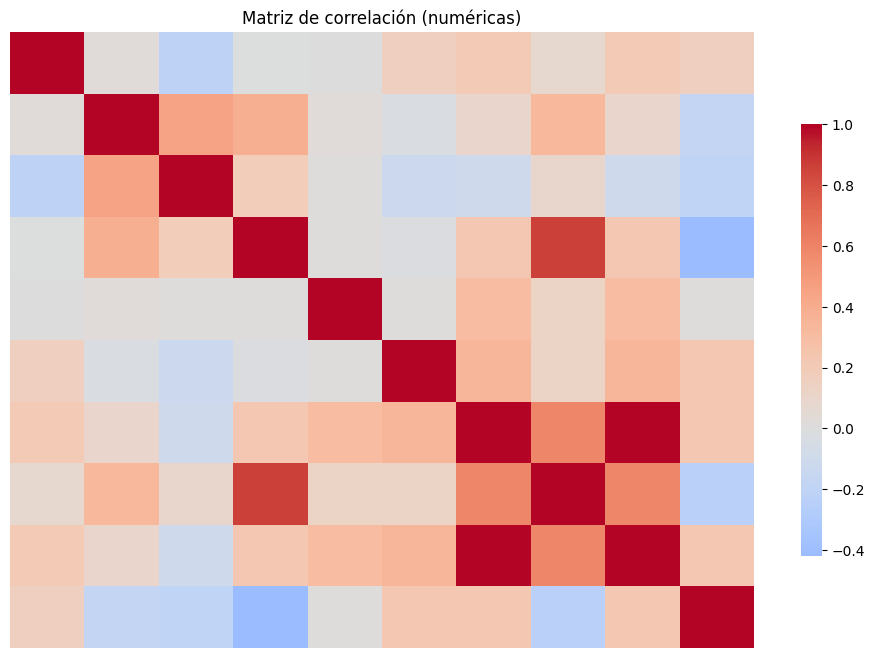

Top 15 correlaciones (abs) con target:
customer_tenure             0.418666
account_Charges.Total       0.240209
cuentas_diarias             0.226906
account_Charges.Monthly     0.226906
account_PaperlessBilling    0.225034
customer_Dependents         0.192958
customer_Partner            0.169754
customer_SeniorCitizen      0.157702
phone_PhoneService          0.014522
Name: Churn, dtype: float64

Features seleccionadas (corr): ['customer_tenure', 'account_Charges.Total', 'cuentas_diarias', 'account_Charges.Monthly', 'account_PaperlessBilling', 'customer_Dependents', 'customer_Partner', 'customer_SeniorCitizen', 'phone_PhoneService']

Columnas candidatas a "Contrato": ['customer_tenure', 'account_Contract_one year', 'account_Contract_two year']
Columnas candidatas a "Gasto Total": ['account_Charges.Monthly', 'account_Charges.Total']


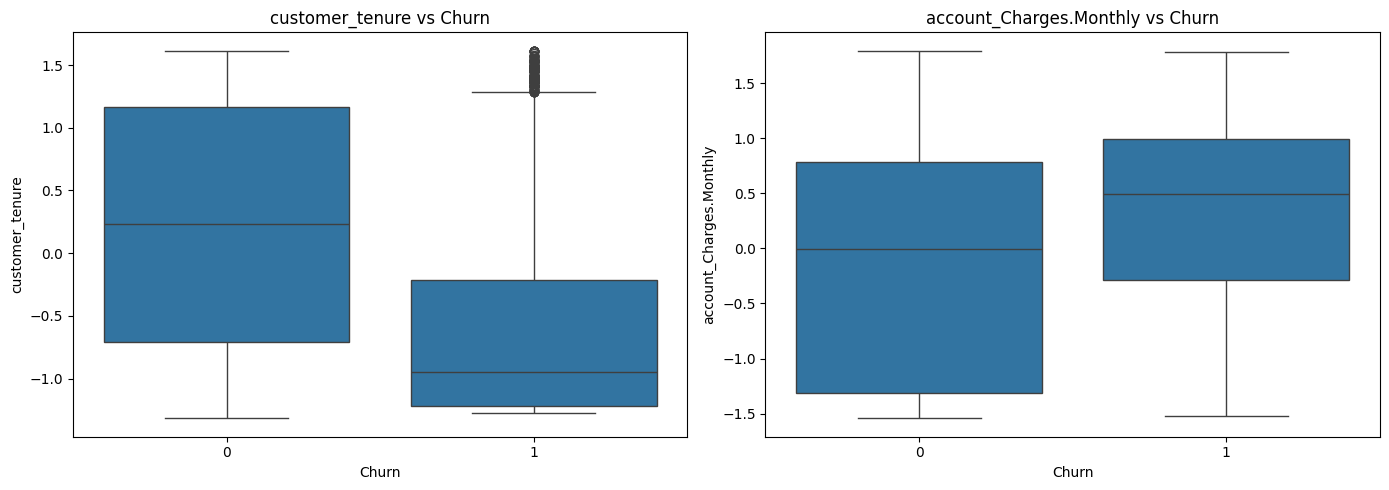

In [25]:
# 3.1 y 3.2 Correlación y relaciones específicas (CORREGIDO)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Fallback si aún no se ejecutó balanceo
if 'X_bal' not in globals() or 'y_bal' not in globals():
    if 'X_encoded' in globals() and 'y' in globals():
        print('Advertencia: usando X_encoded / y porque no se encontró X_bal/y_bal. Ejecuta la celda 2.4 si deseas balancear.')
        X_bal = X_encoded.copy()
        y_bal = y.copy()
    else:
        raise ValueError('Faltan datos para correlación. Ejecuta celdas de preparación (2.x).')

if 'target_col' not in globals():
    raise ValueError('target_col no definido. Ejecuta la celda 2.1.')

# Reconstruimos dataframe numérico con target para correlación
Xy_corr = X_bal.copy()
Xy_corr[target_col] = y_bal.values

# Filtrar solo columnas numéricas para correlación
num_for_corr = [c for c in Xy_corr.columns if np.issubdtype(Xy_corr[c].dtype, np.number)]

corr_matrix = Xy_corr[num_for_corr].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, cbar_kws={'shrink':0.7}, xticklabels=False, yticklabels=False)
plt.title('Matriz de correlación (numéricas)')
plt.show()

# Top features correlacionadas con target
corr_target = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)
print('Top 15 correlaciones (abs) con target:')
print(corr_target.head(15))

# Selección simple de n features (ejemplo)
N_TOP = 20
selected_features = corr_target.head(N_TOP).index.tolist()
print('\nFeatures seleccionadas (corr):', selected_features)

# Visualizaciones específicas (si existen columnas esperadas)
possible_contract = [c for c in X_bal.columns if 'contract' in c.lower() or 'tenure' in c.lower() or 'meses' in c.lower()]
possible_total_charge = [c for c in X_bal.columns if 'total' in c.lower() or 'charge' in c.lower() or 'gasto' in c.lower()]

print('\nColumnas candidatas a "Contrato":', possible_contract)
print('Columnas candidatas a "Gasto Total":', possible_total_charge)

# Tomar la primera coincidencia para cada uno (si existe)
contract_col = possible_contract[0] if possible_contract else None
total_col = possible_total_charge[0] if possible_total_charge else None

fig, axes = plt.subplots(1,2, figsize=(14,5))
if contract_col:
    sns.boxplot(data=Xy_corr, x=y_bal, y=contract_col, ax=axes[0])
    axes[0].set_title(f'{contract_col} vs Churn')
else:
    axes[0].text(0.5,0.5,'No se encontró columna de contrato', ha='center')

if total_col:
    sns.boxplot(data=Xy_corr, x=y_bal, y=total_col, ax=axes[1])
    axes[1].set_title(f'{total_col} vs Churn')
else:
    axes[1].text(0.5,0.5,'No se encontró columna de gasto total', ha='center')

for ax in axes:
    ax.set_xlabel('Churn')
plt.tight_layout()
plt.show()

## Modelado Predictivo 

### 4.1 Train/Test Split
Dividimos los datos en entrenamiento y prueba (70/30) manteniendo la proporción de clases (stratify).

### 4.2 Entrenamiento de modelos
Entrenaremos al menos dos enfoques:
- Modelo sensible a escala: Regresión Logística y/o KNN (usará `X_scaled`).
- Modelo no sensible a escala: Random Forest.
Opcional: SVM lineal para comparar.

### 4.3 Evaluación
Métricas: Accuracy, Precision, Recall, F1, Matriz de Confusión, ROC-AUC.
Se comparan resultados y se analizan posibles overfitting/underfitting.

Se construirá un dataframe comparativo de métricas.

In [26]:
# (Opcional) Diagnóstico previo al modelado
print('--- DIAGNÓSTICO PREVIO ---')
vars_check = ['df','df_work','X_encoded','X_bal','y','y_bal','X_scaled','selected_features','target_col']
for v in vars_check:
    print(f'{v}:', 'OK' if v in globals() else 'MISSING')

if 'X_bal' in globals():
    print('X_bal shape:', X_bal.shape)
if 'X_scaled' in globals():
    print('X_scaled shape:', X_scaled.shape)
if 'y_bal' in globals():
    print('y_bal shape:', y_bal.shape, 'Distribución ->', y_bal.value_counts(normalize=True).to_dict())

if 'selected_features' in globals():
    missing_sel = [f for f in selected_features if f not in X_bal.columns]
    if missing_sel:
        print('Features seleccionadas faltantes en X_bal:', missing_sel)
    else:
        print('Todas las selected_features están en X_bal.')
print('--------------------------')

--- DIAGNÓSTICO PREVIO ---
df: OK
df_work: OK
X_encoded: OK
X_bal: OK
y: OK
y_bal: OK
X_scaled: OK
selected_features: OK
target_col: OK
X_bal shape: (10348, 31)
X_scaled shape: (10348, 31)
y_bal shape: (10348,) Distribución -> {0: 0.5, 1: 0.5}
Todas las selected_features están en X_bal.
--------------------------



Métricas comparativas:
               Modelo  Accuracy  Precision    Recall        F1   ROC_AUC
2        RandomForest  0.780354   0.771197  0.797036  0.783904  0.860596
1                 KNN  0.504992   0.504848  0.503222  0.504034       NaN
3           LinearSVC  0.506602   0.507205  0.453608  0.478912       NaN
0  LogisticRegression  0.506602   0.507215  0.452964  0.478557  0.507794


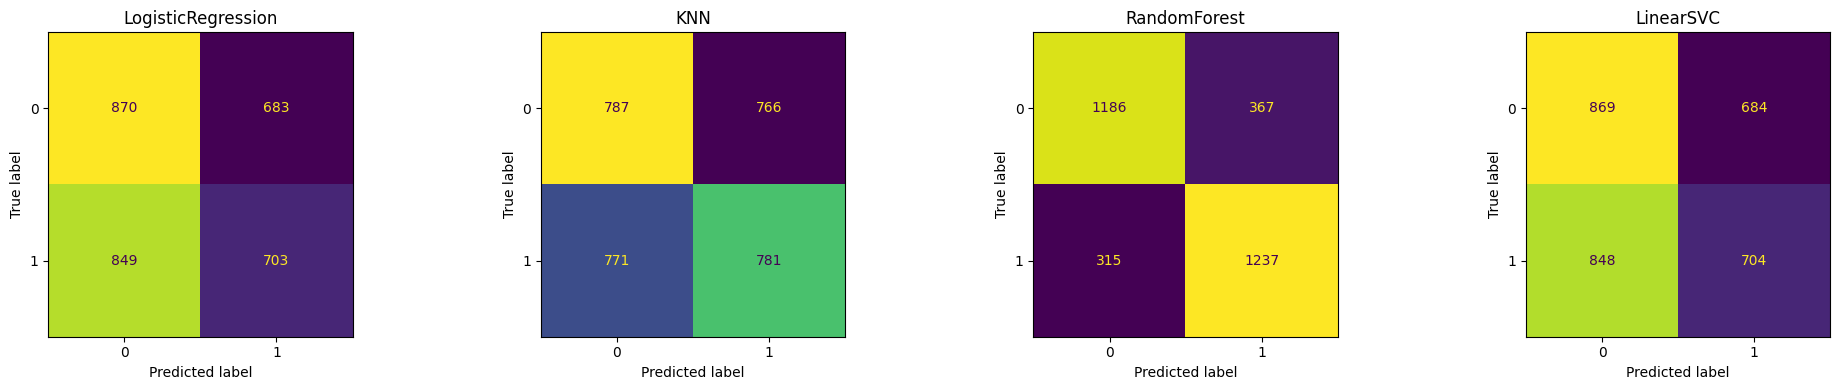

,Modelo,Accuracy,Precision,Recall,F1,ROC_AUC
2,RandomForest,0.780354,0.771197,0.797036,0.783904,0.860596
1,KNN,0.504992,0.504848,0.503222,0.504034,NaN
3,LinearSVC,0.506602,0.507205,0.453608,0.478912,NaN
0,LogisticRegression,0.506602,0.507215,0.452964,0.478557,0.507794


In [27]:
# 4.1, 4.2 y 4.3 Modelado y evaluación (CORREGIDO v2)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Validaciones
needed = ['X_bal','y_bal','X_scaled','imbalanced']
for v in needed:
    if v not in globals():
        raise ValueError(f'Variable {v} ausente. Revisa celdas previas.')

if 'selected_features' not in globals() or not selected_features:
    selected_features = list(X_bal.columns)
    print('selected_features no definido anteriormente: usando todas las columnas.')

USE_SELECTED = True
sel = [f for f in selected_features if f in X_bal.columns]
if len(sel) < len(selected_features):
    print('Advertencia: algunas selected_features no estaban en X_bal y se eliminaron.')
selected_features = sel

X_model_base = X_bal[selected_features] if USE_SELECTED else X_bal

# Indices de columnas para X_scaled
col_index_map = {c:i for i,c in enumerate(X_bal.columns)}
scaled_indices = [col_index_map[c] for c in selected_features]
X_model_scaled_full = X_scaled[:, scaled_indices] if USE_SELECTED else X_scaled

# Split estratificado UNA sola vez para índices consistentes
X_train_ns, X_test_ns, y_train, y_test = train_test_split(
    X_model_base, y_bal, test_size=0.3, random_state=42, stratify=y_bal
)
# Usar las mismas posiciones para datos escalados
train_mask = X_model_base.index.isin(X_train_ns.index)
test_mask = X_model_base.index.isin(X_test_ns.index)
X_train_scaled = X_model_scaled_full[train_mask]
X_test_scaled = X_model_scaled_full[test_mask]

models = {}
results = []

# Regresión Logística
try:
    log_reg = LogisticRegression(max_iter=1000, class_weight='balanced' if imbalanced else None)
    log_reg.fit(X_train_scaled, y_train)
    y_pred_lr = log_reg.predict(X_test_scaled)
    y_proba_lr = log_reg.predict_proba(X_test_scaled)[:,1]
    models['LogisticRegression'] = log_reg
    results.append(('LogisticRegression', y_pred_lr, y_proba_lr))
except Exception as e:
    print('Error LogisticRegression:', e)

# KNN
try:
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    results.append(('KNN', y_pred_knn, None))
    models['KNN'] = knn
except Exception as e:
    print('Error KNN:', e)

# Random Forest
try:
    rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced' if imbalanced else None)
    rf.fit(X_train_ns, y_train)
    y_pred_rf = rf.predict(X_test_ns)
    y_proba_rf = rf.predict_proba(X_test_ns)[:,1]
    models['RandomForest'] = rf
    results.append(('RandomForest', y_pred_rf, y_proba_rf))
except Exception as e:
    print('Error RandomForest:', e)

# SVM Lineal
try:
    svm_lin = LinearSVC(class_weight='balanced' if imbalanced else None)
    svm_lin.fit(X_train_scaled, y_train)
    y_pred_svm = svm_lin.predict(X_test_scaled)
    models['LinearSVC'] = svm_lin
    results.append(('LinearSVC', y_pred_svm, None))
except Exception as e:
    print('Error LinearSVC:', e)

metrics_rows = []
for name, y_pred_m, y_proba_m in results:
    acc = accuracy_score(y_test, y_pred_m)
    prec = precision_score(y_test, y_pred_m, zero_division=0)
    rec = recall_score(y_test, y_pred_m, zero_division=0)
    f1 = f1_score(y_test, y_pred_m, zero_division=0)
    roc = roc_auc_score(y_test, y_proba_m) if y_proba_m is not None else np.nan
    metrics_rows.append({'Modelo': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'ROC_AUC': roc})

metrics_df = pd.DataFrame(metrics_rows).sort_values(by='F1', ascending=False)
print('\nMétricas comparativas:')
print(metrics_df)

# Matrices de confusión
if results:
    fig, axes = plt.subplots(1, len(results), figsize=(5*len(results),4))
    if len(results) == 1:
        axes = [axes]
    for ax, (name, y_pred_m, _) in zip(axes, results):
        cm = confusion_matrix(y_test, y_pred_m)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot(ax=ax, colorbar=False)
        ax.set_title(name)
    plt.tight_layout()
    plt.show()
else:
    print('No se generaron resultados de modelos.')

metrics_df

### 4.4 Curvas ROC, Precision-Recall y Evaluación Extendida
Calculamos curvas ROC y Precision-Recall para los modelos con probabilidades.
También comparamos métricas train vs test para detectar overfitting y realizamos un ajuste de umbral basado en F1 (y alternativa priorizando Recall).

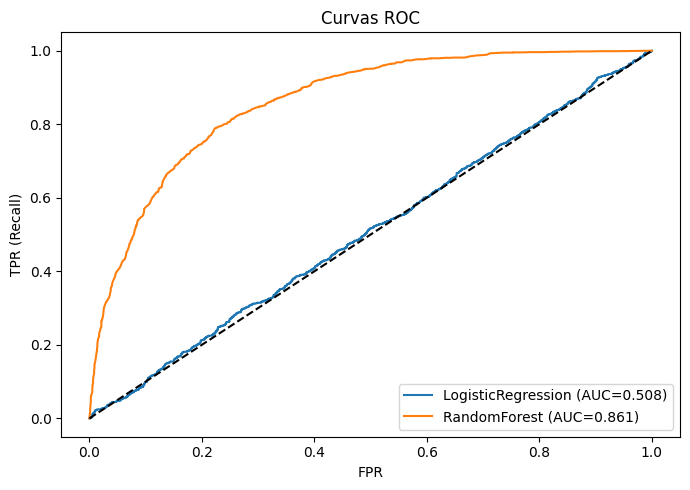

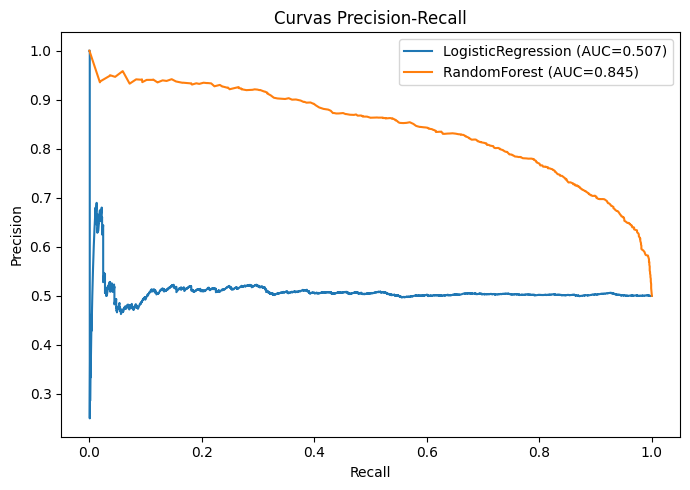


Comparación Train vs Test - RandomForest
Train: {'Accuracy': 0.9966864558884441, 'Precision': 0.9953193832599119, 'Recall': 0.9980673660960795, 'F1': 0.9966914805624483, 'ROC_AUC': 0.9997542938905835}
Test : {'Accuracy': 0.780354267310789, 'Precision': 0.7711970074812967, 'Recall': 0.7970360824742269, 'F1': 0.7839036755386565, 'ROC_AUC': 0.8605957209524633}

Mejor threshold por F1: {'thr': np.float64(0.29), 'f1': 0.7912149013066444, 'precision': 0.6958435207823961, 'recall': 0.916881443298969}
Threshold alternativo (Recall>=0.80): {'thr': np.float64(0.29), 'f1': 0.7912149013066444, 'precision': 0.6958435207823961, 'recall': 0.916881443298969}

Classification report (threshold=0.29)
              precision    recall  f1-score   support

           0       0.88      0.60      0.71      1553
           1       0.70      0.92      0.79      1552

    accuracy                           0.76      3105
   macro avg       0.79      0.76      0.75      3105
weighted avg       0.79      0.76   

In [28]:
# 4.4 Evaluación extendida
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Identificar modelos con probas
def get_probas(model_name, model, X_ns, X_sc):
    if model_name == 'RandomForest':
        return model.predict_proba(X_ns)[:,1]
    if model_name == 'LogisticRegression':
        return model.predict_proba(X_sc)[:,1]
    return None

proba_models = {}
for name, mdl in models.items():
    p = get_probas(name, mdl, X_test_ns, X_test_scaled)
    if p is not None:
        proba_models[name] = p

# Curva ROC
plt.figure(figsize=(7,5))
for name, probs in proba_models.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.title('Curvas ROC')
plt.legend()
plt.tight_layout()
plt.show()

# Curva Precision-Recall
plt.figure(figsize=(7,5))
for name, probs in proba_models.items():
    prec, rec, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f'{name} (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall')
plt.legend()
plt.tight_layout()
plt.show()

# Comparación Train vs Test para un modelo principal (RandomForest si existe, sino Logistic)
primary_name = 'RandomForest' if 'RandomForest' in models else ('LogisticRegression' if 'LogisticRegression' in models else list(models.keys())[0])
primary_model = models[primary_name]

if primary_name == 'RandomForest':
    y_train_pred = primary_model.predict(X_train_ns)
    y_train_proba = primary_model.predict_proba(X_train_ns)[:,1]
    y_test_pred = primary_model.predict(X_test_ns)
    y_test_proba = primary_model.predict_proba(X_test_ns)[:,1]
elif primary_name == 'LogisticRegression':
    y_train_pred = primary_model.predict(X_train_scaled)
    y_train_proba = primary_model.predict_proba(X_train_scaled)[:,1]
    y_test_pred = primary_model.predict(X_test_scaled)
    y_test_proba = primary_model.predict_proba(X_test_scaled)[:,1]
else:
    # fallback sin proba
    y_train_pred = primary_model.predict(X_train_scaled if 'scaled' in primary_name.lower() else X_train_ns)
    y_train_proba = None
    y_test_pred = primary_model.predict(X_test_scaled if 'scaled' in primary_name.lower() else X_test_ns)
    y_test_proba = None

train_metrics = {
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'Precision': precision_score(y_train, y_train_pred, zero_division=0),
    'Recall': recall_score(y_train, y_train_pred, zero_division=0),
    'F1': f1_score(y_train, y_train_pred, zero_division=0)
}
if y_train_proba is not None:
    train_metrics['ROC_AUC'] = roc_auc_score(y_train, y_train_proba)

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred, zero_division=0),
    'Recall': recall_score(y_test, y_test_pred, zero_division=0),
    'F1': f1_score(y_test, y_test_pred, zero_division=0)
}
if y_test_proba is not None:
    test_metrics['ROC_AUC'] = roc_auc_score(y_test, y_test_proba)

print(f'\nComparación Train vs Test - {primary_name}')
print('Train:', train_metrics)
print('Test :', test_metrics)

# Ajuste de umbral (optimizar F1) para primary si tiene proba
if y_test_proba is not None:
    thresholds = np.linspace(0.05,0.95,91)
    best = {'thr':0,'f1':-1,'precision':0,'recall':0}
    alt = {'thr':0,'f1':-1,'precision':0,'recall':0}  # priorizar recall >=0.80 si posible
    for t in thresholds:
        pred_t = (y_test_proba >= t).astype(int)
        f1_t = f1_score(y_test, pred_t, zero_division=0)
        rec_t = recall_score(y_test, pred_t, zero_division=0)
        prec_t = precision_score(y_test, pred_t, zero_division=0)
        if f1_t > best['f1']:
            best = {'thr':t,'f1':f1_t,'precision':prec_t,'recall':rec_t}
        if rec_t >= 0.80 and f1_t > alt['f1']:
            alt = {'thr':t,'f1':f1_t,'precision':prec_t,'recall':rec_t}
    print('\nMejor threshold por F1:', best)
    if alt['f1'] > 0:
        print('Threshold alternativo (Recall>=0.80):', alt)
    chosen_thr = best['thr']
else:
    chosen_thr = 0.5

# Classification report del modelo primario con threshold óptimo
if y_test_proba is not None:
    y_test_pred_thr = (y_test_proba >= chosen_thr).astype(int)
    print(f'\nClassification report (threshold={chosen_thr:.2f})')
    print(classification_report(y_test, y_test_pred_thr, zero_division=0))

# Guardar best model (según F1) + scaler + metadata
try:
    import joblib
    best_row = metrics_df.sort_values('F1', ascending=False).iloc[0]
    best_name = best_row['Modelo']
    best_model = models[best_name]
    artefacts = {
        'model_name': best_name,
        'model': best_model,
        'features': selected_features,
        'scaler': scaler,
        'threshold': chosen_thr,
        'metrics_table': metrics_df
    }
    joblib.dump(artefacts, 'best_churn_model.joblib')
    print(f'\nArtefactos guardados en best_churn_model.joblib (modelo: {best_name})')
except Exception as e:
    print('No se pudo guardar el modelo:', e)

### 4.5 Validación Cruzada y Tuning Ligero (Opcional)
Aplicamos:
- Validación cruzada estratificada (5 folds) para estimar varianza de F1 del mejor modelo actual.
- Búsqueda aleatoria controlada sobre RandomForest y LogisticRegression.
Criterios: n_iter reducido, CV moderado, sólo se actualiza el modelo si mejora F1 en test. Seguro de ejecutar múltiples veces (idempotente).

In [29]:
# 4.5 Tuning ligero y validación cruzada (REVISADO sin SciPy)
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

# Validaciones básicas
missing_vars = [v for v in ['models','metrics_df','X_train_ns','y_train','X_test_ns','y_test','X_train_scaled','X_test_scaled'] if v not in globals()]
if missing_vars:
    raise ValueError(f'Faltan variables requeridas para tuning: {missing_vars}. Ejecuta secciones previas.')

print('[4.5] Validación cruzada y tuning ligero (sin SciPy).')
current_best = metrics_df.sort_values('F1', ascending=False).iloc[0]['Modelo']
print('Mejor modelo actual por F1:', current_best)

# Selección del dataset para CV según modelo
if current_best == 'RandomForest':
    X_cv = X_train_ns; y_cv = y_train
elif current_best in ['LogisticRegression','KNN','LinearSVC']:
    X_cv = X_train_scaled; y_cv = y_train
else:
    X_cv = X_train_ns; y_cv = y_train

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
try:
    cv_scores = cross_val_score(models[current_best], X_cv, y_cv, scoring='f1', cv=skf)
    print('F1 CV (5 folds):', np.round(cv_scores,4), 'mean=', cv_scores.mean().round(4), 'std=', cv_scores.std().round(4))
except Exception as e:
    print('No se pudo ejecutar CV para', current_best, ':', e)

updates = {}

# --- RandomForest tuning ---
if 'RandomForest' in models:
    rf_base = models['RandomForest']
    # Listas discretas (sin scipy)
    rf_param_dist = {
        'n_estimators': [180,220,260,300,340,380,420],
        'max_depth': [4,6,8,10,12,14,16,18,20,None],
        'min_samples_split': [2,3,4,6,8,10,12,15],
        'min_samples_leaf': [1,2,3,4,5,6,8],
        'max_features': ['sqrt','log2', None]
    }
    print('\nTuning RandomForest (RandomizedSearchCV sin SciPy)...')
    try:
        rf_search = RandomizedSearchCV(rf_base, rf_param_dist, n_iter=20, scoring='f1', cv=3, n_jobs=-1, random_state=42, verbose=0)
        rf_search.fit(X_train_ns, y_train)
        print('Mejor RF params:', rf_search.best_params_, 'F1(cv)=', round(rf_search.best_score_,4))
        updates['RandomForest'] = rf_search.best_estimator_
    except Exception as e:
        print('Tuning RF falló:', e)

# --- Logistic Regression tuning ---
if 'LogisticRegression' in models:
    lr_base = models['LogisticRegression']
    # Evitar parámetros incompatibles (mantener penalty l2, solvers compatibles)
    lr_param_dist = {
        'C': [0.01,0.05,0.1,0.5,1,2,5,8,10],
        'solver': ['lbfgs','saga']
    }
    print('\nTuning LogisticRegression (RandomizedSearchCV sin SciPy)...')
    try:
        lr_search = RandomizedSearchCV(lr_base, lr_param_dist, n_iter=12, scoring='f1', cv=3, n_jobs=-1, random_state=42, verbose=0)
        lr_search.fit(X_train_scaled, y_train)
        print('Mejor LR params:', lr_search.best_params_, 'F1(cv)=', round(lr_search.best_score_,4))
        updates['LogisticRegression'] = lr_search.best_estimator_
    except Exception as e:
        print('Tuning Logistic falló:', e)

# --- Actualizar métricas si hay mejoras ---
if updates:
    print('\nRe-evaluando modelos candidatos mejorados...')
    for name, mdl in updates.items():
        try:
            if name == 'RandomForest':
                y_pred = mdl.predict(X_test_ns)
                y_proba = mdl.predict_proba(X_test_ns)[:,1]
            else:  # LogisticRegression
                y_pred = mdl.predict(X_test_scaled)
                y_proba = mdl.predict_proba(X_test_scaled)[:,1]
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1v = f1_score(y_test, y_pred, zero_division=0)
            roc = roc_auc_score(y_test, y_proba)
            prev_f1_series = metrics_df.loc[metrics_df['Modelo']==name,'F1']
            prev_f1 = prev_f1_series.iloc[0] if not prev_f1_series.empty else -1
            if f1v > prev_f1 + 0.001:
                print(f'Mejora {name}: F1 {prev_f1:.3f} -> {f1v:.3f} (actualizado).')
                models[name] = mdl
                metrics_df = metrics_df[metrics_df['Modelo']!=name]
                metrics_df = pd.concat([metrics_df, pd.DataFrame([{'Modelo':name,'Accuracy':acc,'Precision':prec,'Recall':rec,'F1':f1v,'ROC_AUC':roc}])], ignore_index=True)
            else:
                print(f'Sin mejora significativa en {name} (nuevo F1={f1v:.3f}, previo={prev_f1:.3f}).')
        except Exception as e_eval:
            print(f'Error evaluando modelo {name} mejorado:', e_eval)
    metrics_df = metrics_df.sort_values('F1', ascending=False).reset_index(drop=True)
else:
    print('No hubo tuning exitoso para actualizar modelos.')

print('\nMétricas (posible actualización):')
print(metrics_df)

[4.5] Validación cruzada y tuning ligero (sin SciPy).
Mejor modelo actual por F1: RandomForest
F1 CV (5 folds): [0.7756 0.7776 0.7913 0.7785 0.7713] mean= 0.7789 std= 0.0067

Tuning RandomForest (RandomizedSearchCV sin SciPy)...
Tuning RF falló: No module named '_posixsubprocess'

Tuning LogisticRegression (RandomizedSearchCV sin SciPy)...
Tuning Logistic falló: No module named '_posixsubprocess'
No hubo tuning exitoso para actualizar modelos.

Métricas (posible actualización):
               Modelo  Accuracy  Precision    Recall        F1   ROC_AUC
2        RandomForest  0.780354   0.771197  0.797036  0.783904  0.860596
1                 KNN  0.504992   0.504848  0.503222  0.504034       NaN
3           LinearSVC  0.506602   0.507205  0.453608  0.478912       NaN
0  LogisticRegression  0.506602   0.507215  0.452964  0.478557  0.507794
F1 CV (5 folds): [0.7756 0.7776 0.7913 0.7785 0.7713] mean= 0.7789 std= 0.0067

Tuning RandomForest (RandomizedSearchCV sin SciPy)...
Tuning RF falló: N

## Interpretacion y conclusiones 

### 5.1 Importancia / Interpretación de Variables
Analizamos:
- Coeficientes Regresión Logística (signo e intensidad).
- Importancias Random Forest (reducción de impureza).
- Limitaciones: KNN y LinearSVC (sin probas). Para SVC lineal se reportan coeficientes (si se usa).

Se construye tabla unificada ordenada por importancia relativa.

### 5.2 Conclusiones parciales de interpretación
Identificar patrones: variables con peso positivo (aumentan probabilidad de churn) vs negativo (protegen contra churn).

### 5.3 Interpretabilidad con SHAP (Opcional)
Intentamos calcular valores SHAP para RandomForest (rápido con TreeExplainer). Si no está instalado `shap`, se muestra cómo instalar. Si no hay RF, se intenta fallback con Logistic (KernelExplainer más lento) o permutation importance.

In [30]:
# 5.3 SHAP interpretabilidad
import importlib, numpy as np

if 'models' not in globals() or not models:
    print('No hay modelos entrenados. Ejecuta sección 4 primero.')
else:
    has_shap = importlib.util.find_spec('shap') is not None
    if not has_shap:
        print('Librería shap no instalada. Instala con: pip install shap')
    else:
        try:
            import shap, matplotlib.pyplot as plt
            # Preferir RandomForest
            model = None
            data = None
            scaled = False
            if 'RandomForest' in models:
                model = models['RandomForest']
                data = X_test_ns
            elif 'LogisticRegression' in models:
                model = models['LogisticRegression']
                data = X_test_scaled
                scaled = True
            else:
                print('Ni RandomForest ni LogisticRegression disponibles para SHAP.')
            if model is not None:
                # Sample para rapidez
                if scaled:
                    # data es numpy; tomar subset indices
                    max_n = min(400, data.shape[0])
                    idx = np.random.choice(range(data.shape[0]), max_n, replace=False)
                    data_sample = data[idx]
                else:
                    max_n = min(400, data.shape[0])
                    data_sample = data.sample(max_n, random_state=42)
                print(f'Calculando SHAP sobre muestra de {max_n} filas...')
                if hasattr(model, 'feature_importances_'):
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(data_sample)
                    # Clasificación binaria -> lista
                    if isinstance(shap_values, list) and len(shap_values)==2:
                        sv = shap_values[1]
                    else:
                        sv = shap_values
                    shap.summary_plot(sv, data_sample, feature_names=selected_features, show=False)
                    plt.title('SHAP Summary')
                    plt.show()
                else:
                    # KernelExplainer fallback (más lento)
                    print('Usando KernelExplainer (puede ser lento). Limitando a 200 filas.')
                    if scaled:
                        n2 = min(200, data_sample.shape[0])
                        data_kernel = data_sample[:n2]
                        background = data_kernel[:40]
                    else:
                        data_kernel = data_sample.sample(min(200, data_sample.shape[0]), random_state=42)
                        background = data_kernel.sample(min(40, data_kernel.shape[0]), random_state=42)
                    explainer = shap.KernelExplainer(lambda X: model.predict_proba(X)[:,1], background)
                    shap_vals = explainer.shap_values(data_kernel)
                    shap.summary_plot(shap_vals, data_kernel, feature_names=selected_features, show=False)
                    plt.title('SHAP Summary (Kernel)')
                    plt.show()
        except Exception as e:
            print('Error SHAP:', e)

# Fallback permutation importance si no hay shap
if 'has_shap' in globals() and not has_shap:
    try:
        from sklearn.inspection import permutation_importance
        if 'RandomForest' in models:
            print('Calculando permutation importance (fallback).')
            rf = models['RandomForest']
            perm = permutation_importance(rf, X_test_ns, y_test, scoring='f1', n_repeats=8, random_state=42)
            import pandas as pd
            pi_df = pd.DataFrame({'feature': selected_features,
                                  'perm_import_mean': perm.importances_mean,
                                  'perm_import_std': perm.importances_std}) \
                     .sort_values('perm_import_mean', ascending=False).head(15)
            print(pi_df)
        else:
            print('No RandomForest para permutation importance.')
    except Exception as e:
        print('Error permutation importance:', e)

Librería shap no instalada. Instala con: pip install shap
Calculando permutation importance (fallback).
                    feature  perm_import_mean  perm_import_std
0           customer_tenure          0.163031         0.007487
3   account_Charges.Monthly          0.085059         0.008727
2           cuentas_diarias          0.078575         0.008015
1     account_Charges.Total          0.066585         0.005012
4  account_PaperlessBilling          0.027359         0.004429
7    customer_SeniorCitizen          0.016790         0.002575
5       customer_Dependents          0.014800         0.003417
6          customer_Partner          0.013180         0.004016
8        phone_PhoneService          0.008514         0.001031
                    feature  perm_import_mean  perm_import_std
0           customer_tenure          0.163031         0.007487
3   account_Charges.Monthly          0.085059         0.008727
2           cuentas_diarias          0.078575         0.008015
1     account_

### 6. Conclusiones Estratégicas
(Completar tras evaluar resultados.)

Resumen sugerido:
1. Mejor modelo y justificación (métricas clave: F1 / Recall / ROC-AUC).
2. Principales variables que impulsan el churn (mencionar signo/efecto si aplica).
3. Patrones detectados (ej.: clientes con corto tiempo de contrato, alto número de incidencias, tipos de plan, etc.).
4. Riesgos de overfitting/underfitting observados y mitigaciones propuestas.
5. Recomendaciones de retención:
   - Acciones preventivas sobre segmentos de alto riesgo.
   - Ofertas / planes personalizados.
   - Mejora en servicio al cliente / soporte.
6. Próximos pasos:
   - Ajuste de hiperparámetros (Grid/Random Search, Bayesian Optimization).
   - Incorporar variables externas (uso, soporte, NPS...).
   - Implementar monitoreo de drift y actualización periódica del modelo.

> Completa esta sección con hallazgos reales tras ejecutar todas las celdas.

#### 6.1 Borrador automático de conclusiones
La siguiente celda genera un borrador basado en métricas, importancias y threshold seleccionado. Revísalo y edita para versión final ejecutiva.

In [31]:
# 6.1 Generación de borrador de conclusiones
import pandas as pd
import textwrap

if 'metrics_df' not in globals():
    raise ValueError('Ejecuta la sección de modelado antes de generar conclusiones.')

best_model_name = metrics_df.sort_values('F1', ascending=False).iloc[0]['Modelo']

# Recoger importancias si existen
def top_importances(model_key, n=8):
    if 'all_importances' in globals():
        df_imp = all_importances[all_importances['model']==model_key].copy()
        if not df_imp.empty:
            return df_imp.sort_values('abs_importance', ascending=False).head(n)[['feature','importance']]
    return pd.DataFrame()

rf_imp_tbl = top_importances('RandomForest')
lr_imp_tbl = top_importances('LogisticRegression')

lines = []
lines.append(f"Modelo con mejor F1: {best_model_name} (F1={metrics_df.sort_values('F1', ascending=False).iloc[0]['F1']:.3f}).")

if best_model_name == 'RandomForest' and not rf_imp_tbl.empty:
    lines.append('Principales variables (RandomForest) por importancia absoluta:')
    for _, r in rf_imp_tbl.iterrows():
        lines.append(f" - {r['feature']}: {r['importance']:.4f}")
elif best_model_name == 'LogisticRegression' and not lr_imp_tbl.empty:
    lines.append('Principales variables (LogisticRegression) por |coeficiente|:')
    for _, r in lr_imp_tbl.iterrows():
        lines.append(f" - {r['feature']}: {r['importance']:.4f}")

if 'train_metrics' in globals() and 'test_metrics' in globals():
    f1_gap = train_metrics['F1'] - test_metrics['F1'] if 'F1' in train_metrics and 'F1' in test_metrics else None
    if f1_gap is not None:
        if f1_gap > 0.05:
            lines.append(f'Observación: Posible overfitting (F1 train {train_metrics["F1"]:.3f} vs test {test_metrics["F1"]:.3f}). Recomendar tuning / regularización.')
        else:
            lines.append('Generalización estable: No se observa gap significativo entre train y test en F1.')

if 'chosen_thr' in globals():
    lines.append(f'Threshold operativo sugerido: {chosen_thr:.2f} optimizado para F1.')

lines.append('Recomendaciones preliminares de retención:')
lines.append(' - Priorizar intervención temprana en segmentos de alto riesgo identificados por top features.')
lines.append(' - Diseñar ofertas específicas para perfiles con alta importancia positiva en churn.')
lines.append(' - Revisar políticas de permanencia / contrato si la duración aparece como factor crítico.')
lines.append(' - Monitorizar mensualmente métricas (F1, Recall) y recalibrar threshold si cambia la distribución.')

conclusion_text = '\n'.join(lines)
print('\n===== BORRADOR CONCLUSIONES =====\n')
print(conclusion_text)
print('\n=================================\n')


===== BORRADOR CONCLUSIONES =====

Modelo con mejor F1: RandomForest (F1=0.784).
Principales variables (RandomForest) por importancia absoluta:
 - customer_tenure: 0.2616
 - account_Charges.Total: 0.2233
 - account_Charges.Monthly: 0.2065
 - cuentas_diarias: 0.2042
 - account_PaperlessBilling: 0.0295
 - customer_Dependents: 0.0230
 - customer_Partner: 0.0225
 - customer_SeniorCitizen: 0.0210
Observación: Posible overfitting (F1 train 0.997 vs test 0.784). Recomendar tuning / regularización.
Threshold operativo sugerido: 0.29 optimizado para F1.
Recomendaciones preliminares de retención:
 - Priorizar intervención temprana en segmentos de alto riesgo identificados por top features.
 - Diseñar ofertas específicas para perfiles con alta importancia positiva en churn.
 - Revisar políticas de permanencia / contrato si la duración aparece como factor crítico.
 - Monitorizar mensualmente métricas (F1, Recall) y recalibrar threshold si cambia la distribución.




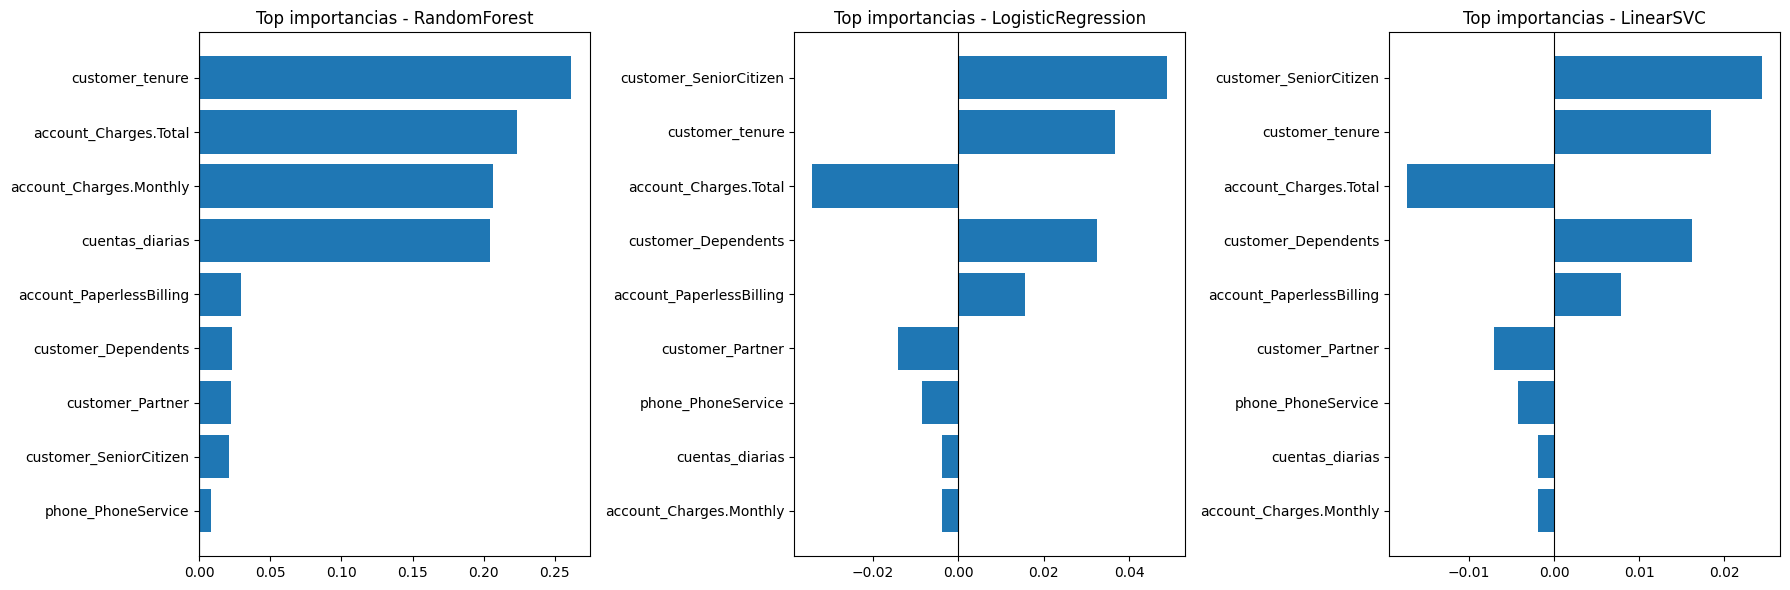

,feature,importance,model,type,abs_importance
9,customer_tenure,0.261592,RandomForest,gini_importance,0.261592
10,account_Charges.Total,0.223282,RandomForest,gini_importance,0.223282
12,account_Charges.Monthly,0.206545,RandomForest,gini_importance,0.206545
11,cuentas_diarias,0.204186,RandomForest,gini_importance,0.204186
7,customer_SeniorCitizen,0.048918,LogisticRegression,coef,0.048918
0,customer_tenure,0.036598,LogisticRegression,coef,0.036598
1,account_Charges.Total,-0.034316,LogisticRegression,coef,0.034316
5,customer_Dependents,0.032404,LogisticRegression,coef,0.032404
13,account_PaperlessBilling,0.029511,RandomForest,gini_importance,0.029511
25,customer_SeniorCitizen,0.024444,LinearSVC,coef,0.024444


In [32]:
# 5.1 Importancia de variables (CORREGIDO)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if 'models' not in globals() or not models:
    raise ValueError('No hay modelos entrenados. Ejecuta la celda de modelado primero.')

if 'selected_features' not in globals() or not selected_features:
    selected_features = list(X_bal.columns)

importance_frames = []

# Coeficientes Regresión Logística
if 'LogisticRegression' in models:
    try:
        lr = models['LogisticRegression']
        coef = lr.coef_[0]
        feat_names = selected_features
        if len(feat_names) != len(coef):
            print('Ajuste longitud coef vs features (Logistic).')
            feat_names = feat_names[:len(coef)]
        lr_imp = pd.DataFrame({'feature': feat_names, 'importance': coef, 'model':'LogisticRegression', 'type':'coef'})
        importance_frames.append(lr_imp)
    except Exception as e:
        print('Error extrayendo coeficientes LR:', e)

# Random Forest importances
if 'RandomForest' in models:
    try:
        rf = models['RandomForest']
        feat_names_rf = selected_features
        if len(feat_names_rf) != len(rf.feature_importances_):
            print('Ajuste longitud importancias vs features (RF).')
            feat_names_rf = feat_names_rf[:len(rf.feature_importances_)]
        rf_imp = pd.DataFrame({'feature': feat_names_rf, 'importance': rf.feature_importances_, 'model':'RandomForest', 'type':'gini_importance'})
        importance_frames.append(rf_imp)
    except Exception as e:
        print('Error importancias RF:', e)

# Linear SVC (coeficientes)
if 'LinearSVC' in models:
    try:
        svc = models['LinearSVC']
        svc_coef = svc.coef_[0]
        feat_names_svc = selected_features
        if len(feat_names_svc) != len(svc_coef):
            feat_names_svc = feat_names_svc[:len(svc_coef)]
        svc_imp = pd.DataFrame({'feature': feat_names_svc, 'importance': svc_coef, 'model':'LinearSVC', 'type':'coef'})
        importance_frames.append(svc_imp)
    except Exception as e:
        print('Error coeficientes LinearSVC:', e)

if importance_frames:
    all_importances = pd.concat(importance_frames, ignore_index=True)
    all_importances['abs_importance'] = all_importances['importance'].abs()

    top_plot = all_importances.sort_values('abs_importance', ascending=False).groupby('model').head(10)
    g_models = top_plot['model'].unique()
    n_models = len(g_models)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 6))
    if n_models == 1:
        axes = [axes]
    for ax, m in zip(axes, g_models):
        sub = top_plot[top_plot.model==m].sort_values('abs_importance', ascending=True)
        ax.barh(sub['feature'], sub['importance'])
        ax.set_title(f'Top importancias - {m}')
        ax.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    display(all_importances.sort_values('abs_importance', ascending=False).head(25))
else:
    print('No hay importancias disponibles.')